<a href="https://colab.research.google.com/github/sanduerhan/Licenta/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
from nltk.corpus import stopwords, words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import gensim
import re, string
from string import punctuation, digits

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten ,Embedding,Input,LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

col_list = ["Column2", "Column3"]
dataset = pd.read_excel("Training.data.xlsx", usecols=col_list)
testset = pd.read_excel("Dev.xlsx", usecols=col_list)


def add_category_id(dataset):
  dataset['category_id'] = dataset['Column3'].factorize()[0]
  category_id_dataset = dataset[['Column3', 'category_id']].drop_duplicates()

  category_to_id = dict(category_id_dataset.values)
  id_to_category = dict(category_id_dataset[['category_id', 'Column3']].values)
  return dataset,category_to_id, id_to_category

dataset, category_to_id_train, id_to_category_train = add_category_id(dataset)
testset, category_to_id_test, id_to_category_test = add_category_id(testset)
dataset = dataset.sample(frac = 1)
testset = testset.sample(frac = 1)
train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]


In [60]:
print(dataset["Column2"].head)

<bound method NDFrame.head of 894     dad got bottle irish cream yesterday downed bu...
6817    ¿ interest ever look people realise one really...
5629    never thought would starting become depressed ...
4777    running absolutely terrified less minutes deca...
2160    lonely know belongs need towrite little first ...
                              ...                        
271     think gonna make already spent lot work today ...
7719    hour already slipped back self harming multipl...
4312    ive never spent another friend even give fuck ...
1690    dental care tips narcoleptic depressed two big...
3646    depression ripping relationship apart know any...
Name: Column2, Length: 8068, dtype: object>


In [ ]:
train_tweets = dataset['Column2'].tolist()
test_tweets = testset['Column2'].tolist()
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['Column2'] == i ].index, inplace=True)
    return df

dataset = keep_uniques(train_tweets, dataset)
testset = keep_uniques(test_tweets, testset)

print(len(testset))

4062


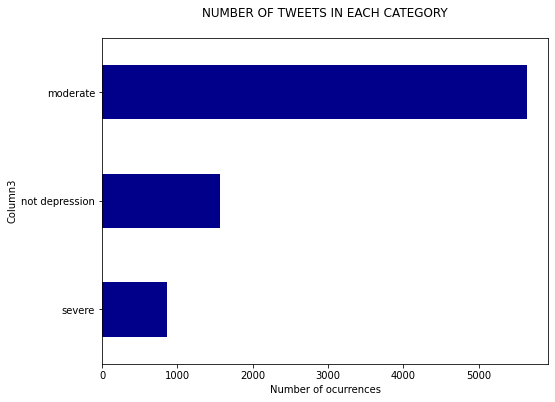

In [5]:
fig = plt.figure(figsize=(8,6))
colors = ['darkblue','darkblue','darkblue']
dataset.groupby('Column3').Column2.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF TWEETS IN EACH CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

# PreProcessing

In [5]:
!pip install tweet-preprocessor
import preprocessor as p

def preprocess_tweets(text):
  return p.clean(text)

print(preprocess_tweets(train_x[0]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Waiting for my mind to have a breakdown once the New Year feeling isnt there anymore : I dont know about anyone else, but Im a little bit worried that Ill go back to being depressed in a few days time or something. Last year, I tried not to have any breakdowns for the start of . A mere days later, I broke down crying. I wasnt the same for that entire year. Up until December, where I was ok that month. Now I just wait... its a weird way to act and feel, but it feels a bit normal.


In [ ]:
# cleaning the text : deleting the emojis, the existing emails, the punctuation, the present digits,
# the hyperlinks and the stopwords (a,the,is, etc)

def delete_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)  # no emoji


def delete_digits(text):
    text = text.lower()
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    clean = text.translate(str.maketrans('', '', punctuation + '’“”'))
    return clean


stop = set(stopwords.words('english'))
stop.add('gtpoplt')
stop.add('new')
stop.add('year')
stop.add('eve')
stop.add('years')
stop.add('ti')
stop.add('ame')
stop.add('folks')
punct = list(string.punctuation)
stop.update(punct)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def remove_hyperlinks(text):
    for word in text:
        if re.match(r'^http', word):
            text.remove(word)
    return " ".join(text)

def remove_emails(text):
    text = text.split()
    for i in text:
        if '@' in i.strip().lower():
            text.remove(i)
    return " ".join(text)

contraction_dict = {"youre":"you are","im": "i am","wouldnt": "would not","itll": "it will","wasnt": "was not","dont": "do not","ill": "i will","isnt": "is not","cant": "cannot","arent": "are not","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# def denoise_text(text):
#     text = replace_contractions(text)
#     text = remove_words(text)
#     text = remove_emails(text)
#     text = delete_punctuation(text)
#     text = delete_emoji(text)
#     text = delete_digits(text)
#     text = remove_stopwords(text)
#     text = text.split()
#     text = remove_hyperlinks(text)
#     return text



train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]

for i in range(len(train_x)):
  train_x[i] = replace_contractions(train_x[i])
  train_x[i] = remove_emails(train_x[i])
  train_x[i] = delete_punctuation(train_x[i])
  train_x[i] = delete_emoji(train_x[i])
  train_x[i] = delete_digits(train_x[i])
  train_x[i] = remove_stopwords(train_x[i])

for i in range(len(test_x)):
  test_x[i] = replace_contractions(test_x[i])
  test_x[i] = remove_emails(test_x[i])
  test_x[i] = delete_punctuation(test_x[i])
  test_x[i] = delete_emoji(test_x[i])
  test_x[i] = delete_digits(test_x[i])
  test_x[i] = remove_stopwords(test_x[i])



In [ ]:
print(train_x[0])

waiting mind breakdown feeling anymore know anyone else little bit worried go back depressed days something last tried breakdowns start mere days later broke crying entire december ok month wait weird way act feel feels bit normal


# Lemmatization

In [8]:
# lemmatization : crying -> cry, days -> day

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemm(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word, get_pos(word)) for word in text]
    return " ".join(sar_list_lemmatizer)

train_x = train_x.apply(lemm)
test_x = test_x.apply(lemm)

In [9]:
print(train_x[0])

wait mind breakdown feel anymore know anyone else little bit worried go back depressed day something last try breakdown start mere day later broke cry entire december ok month wait weird way act feel feel bit normal


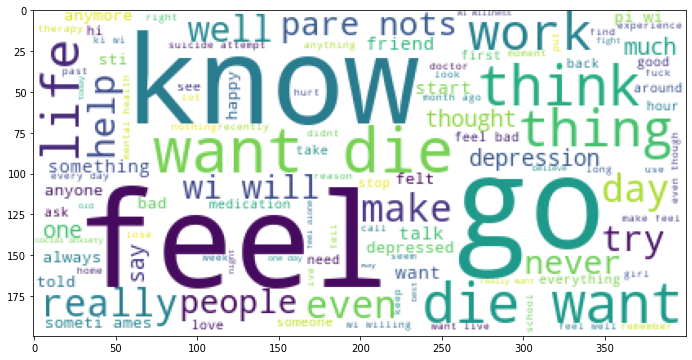

In [ ]:
plt.figure(figsize=(12,6))
text = ' '.join(train_x[dataset['Column3']=='severe'])
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

# Count Vectorizer

In [ ]:
# CountVectorizer reprezentation for the user tweets
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(train_x)

x_test_cv = vectorizer.transform(test_x)
print(x_train_cv.shape)

(8068, 10252)


# Data imbalance handling

In [ ]:
sm = SMOTE(random_state = 42)
res_x, res_y = sm.fit_resample(x_train_cv, train_y)
print("After OverSampling, counts of label '2': {}".format(sum(res_y == 2)))

After OverSampling, counts of label '2': 5647


In [ ]:
os = RandomOverSampler()
res_x2, res_y2 = os.fit_resample(x_train_cv, train_y)

# Tf-Idf 

In [ ]:
# Tf-idf reprezentation for the tweets
from sklearn.feature_selection import chi2
vectorizer = TfidfVectorizer(max_df = 0.15,min_df = 5, ngram_range=(1,2), stop_words='english')
train_x_tf = vectorizer.fit_transform(train_x)
test_x_tf = vectorizer.transform(test_x)
N = 2
# for Product, category_id in sorted(category_to_id_train.items()):
#     features_chi2 = chi2(train_x_tf, train_y == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(vectorizer.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(Product))
#     print(" Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#     print(" Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
res_tfx, res_tfy = sm.fit_resample(train_x_tf, train_y)
print(train_x_tf.shape)
print(res_tfx.shape)

NameError: ignored

# Word2Vec

In [55]:
# Word2Vec reprezentation
def w2v(train_x):
  corpus_text = 'n'.join(train_x)
  data = []
  # iterate through each sentence in the file
  for i in sent_tokenize(corpus_text):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

  model1 = gensim.models.Word2Vec(min_count = 5,size = 300, window = 5, alpha = 0.025)
  model1.build_vocab(data)
  print(len(model1.wv.vocab))
  model1.train(data, total_examples = model1.corpus_count, epochs=30)

  print(model1.wv.most_similar(positive=["depression"]))

  vocab = list(model1.wv.vocab.keys())

  word2vec_dict ={}
  for word in vocab:
    word2vec_dict[word] = model1.wv.get_vector(word)

  maxi=-1
  for i,rev in enumerate(train_x):
    tokens=rev.split()
    if(len(tokens)>maxi):
      maxi=len(tokens)

  tok = Tokenizer()
  tok.fit_on_texts(train_x)
  vocab_size = len(tok.word_index) + 1
  encd_rev = tok.texts_to_sequences(train_x)

  max_len = 1464
  embed_dim = 300
  pad_rev = pad_sequences(encd_rev, maxlen=max_len, padding='post')
  embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
  for word,i in tok.word_index.items():
    embed_vector=word2vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
      embed_matrix[i]=embed_vector
  return embed_matrix,pad_rev,vocab_size,embed_dim,max_len

In [ ]:
sent = [row.split() for row in train_x]

In [19]:
from gensim.models.phrases import Phrases, Phraser


In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
print(sentences)

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     )

In [ ]:
w2v_model.build_vocab(sentences)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(5675934, 16754460)

In [ ]:
w2v_model.wv.most_similar(positive=["depression"])

[('anxiety', 0.5718693733215332),
 ('diagnose', 0.5230121612548828),
 ('disorder', 0.4272606372833252),
 ('ptsd', 0.3910037577152252),
 ('severe', 0.3898566663265228),
 ('adhd', 0.37263554334640503),
 ('recently', 0.37178850173950195),
 ('symptom', 0.3715326488018036),
 ('battling', 0.3693320155143738),
 ('struggle', 0.35999664664268494)]

In [53]:
def w2vv(train_x):
  sent = [row.split() for row in train_x]
  
  phrases = Phrases(sent, min_count=30)
  bigram = Phraser(phrases)
  sentences = bigram[sent]
  w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     )
  w2v_model.build_vocab(sentences)
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  vocab = list(w2v_model.wv.vocab.keys())

  word2vec_dict ={}
  for word in vocab:
    word2vec_dict[word] = w2v_model.wv.get_vector(word)

  tok = Tokenizer()
  tok.fit_on_texts(sent)
  vocab_size = 10339
  encd_rev = tok.texts_to_sequences(sent)

  max_len = 1464
  embed_dim = 300
  pad_rev = pad_sequences(encd_rev, maxlen=max_len, padding='post')
  embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
  for word,i in tok.word_index.items():
    embed_vector=word2vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
      embed_matrix[i]=embed_vector
  return embed_matrix,pad_rev,vocab_size,embed_dim,max_len

NameError: ignored

In [37]:
embeddings_train,pad_rev_train,vocab_train,embed_dim_train,max_len = w2vv(train_x)


In [56]:
embeddings_test,pad_rev_test,vocab_test,embed_dim_test,max_len_test = w2v(test_x)

3878
[('also', 0.9999441504478455), ('reality', 0.9999353885650635), ('isolated', 0.9999352693557739), ('thats', 0.9999350309371948), ('idea', 0.9999345541000366), ('effect', 0.9999323487281799), ('literally', 0.9999312162399292), ('coronavirus', 0.9999300241470337), ('si', 0.9999276399612427), ('recently', 0.9999231696128845)]


In [44]:
print(embeddings_train.shape)
print(embeddings_test.shape)

(10339, 300)
(10339, 300)


# Naive Bayes

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_x, res_y)
pred_y = naive_bayes_classifier.predict(x_test_cv)

score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

Accuracy 0.521824423737126
              precision    recall  f1-score   support

           0       0.57      0.82      0.67      2198
           1       0.63      0.15      0.24      1522
           2       0.19      0.30      0.23       358

    accuracy                           0.52      4078
   macro avg       0.46      0.42      0.38      4078
weighted avg       0.56      0.52      0.47      4078



In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(res_tfx, res_tfy)
# naive_bayes_classifier.fit(train_x_tf, train_y)
pred_y = naive_bayes_classifier.predict(test_x_tf)
score1 = metrics.accuracy_score(test_y, pred_y)
print("Accuracy " + str(score1))
print(metrics.classification_report(test_y, pred_y))

Accuracy 0.3021088769004414
              precision    recall  f1-score   support

           0       0.55      0.26      0.36      2198
           1       0.52      0.23      0.32      1522
           2       0.13      0.85      0.22       358

    accuracy                           0.30      4078
   macro avg       0.40      0.45      0.30      4078
weighted avg       0.50      0.30      0.33      4078



# AdaBoost

In [ ]:
# res_x2, res_y2 = sm.fit_resample(train_x_tf, train_y)
ada = AdaBoostClassifier()

# boost = ada.fit(train_x_tf, train_y)
boost = ada.fit(res_tfx, res_tfy)
pred_y = boost.predict(test_x_tf)
print("AdaBoost Classifier Model Accuracy:", accuracy_score(test_y, pred_y))
print(metrics.classification_report(test_y, pred_y))

AdaBoost Classifier Model Accuracy: 0.4681216282491417
              precision    recall  f1-score   support

           0       0.61      0.35      0.45      2198
           1       0.46      0.64      0.54      1522
           2       0.23      0.43      0.30       358

    accuracy                           0.47      4078
   macro avg       0.43      0.48      0.43      4078
weighted avg       0.52      0.47      0.47      4078



# Regression

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 4.}

model = LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight = class_weight)
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3)
# model = model.fit(train_x_tf, train_y)
# y_pred = model.predict(test_x_tf)

# model = model.fit(res_tfx, res_tfy)
# y_pred = model.predict(test_x_tf)

model = model.fit(pad_rev_train, train_y)
y_pred = model.predict(pad_rev_test)
print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


Regression Classifier Model Accuracy: 0.4494850416871015
              precision    recall  f1-score   support

           0       0.57      0.50      0.53      2198
           1       0.45      0.43      0.44      1522
           2       0.12      0.24      0.16       358

    accuracy                           0.45      4078
   macro avg       0.38      0.39      0.38      4078
weighted avg       0.49      0.45      0.47      4078

[[1089  688  421]
 [ 653  658  211]
 [ 157  115   86]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


In [ ]:

class_weight = {0: 1.,
                1: 3.,
                2: 6.}
model = LinearSVC()
model = model.fit(res_tfx, res_tfy)
y_pred = model.predict(test_x_tf)
print("Svc Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)


Svc Classifier Model Accuracy: 0.5255026974006866
              precision    recall  f1-score   support

           0       0.62      0.58      0.60      2198
           1       0.48      0.45      0.47      1522
           2       0.30      0.51      0.38       358

    accuracy                           0.53      4078
   macro avg       0.47      0.51      0.48      4078
weighted avg       0.54      0.53      0.53      4078

[[1279  654  265]
 [ 689  681  152]
 [ 105   70  183]]


In [ ]:

class_weight = {0: 1.,
                1: 3.,
                2: 5.}
model = RandomForestClassifier(class_weight=class_weight)
model = model.fit(train_x_tf,train_y)
y_pred = model.predict(test_x_tf)
print("RandomForest Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)

RandomForest Classifier Model Accuracy: 0.5848455125061305
              precision    recall  f1-score   support

           0       0.58      0.92      0.71      2198
           1       0.67      0.19      0.29      1522
           2       0.50      0.21      0.30       358

    accuracy                           0.58      4078
   macro avg       0.58      0.44      0.43      4078
weighted avg       0.61      0.58      0.52      4078

[[2023  127   48]
 [1209  287   26]
 [ 269   14   75]]


# F1 metric

In [10]:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Neural Network

In [57]:
class_weight = {0: 1.,
                1: 3.,
                2: 5.}

def split(pad_rev,train_y):
  Y=keras.utils.to_categorical(train_y)  # one hot target as required by NN.
  x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.1,random_state=42)
  return x_train, x_test,y_train,y_test
def network(vocab_size,embed_dim,embed_matrix):
  model=Sequential()
  model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_len,embeddings_initializer=Constant(embed_matrix)))
  model.add(Flatten())
  model.add(Dense(16,activation='relu', kernel_regularizer='l2',bias_regularizer='l2'))
  model.add(Dropout(0.20))
  model.add(Dense(3,activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
  loss=f1_loss,metrics=[f1])
  return model

x_train,x_test,y_train,y_test = split(pad_rev_train,train_y)
model = network(vocab_train,embed_dim_train,embeddings_train)
x_valid, x_x, y_valid, y_y = split(pad_rev_test,test_y)
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_valid,y_valid), class_weight = class_weight)


Epoch 1/10
113/114 [============================>.] - ETA: 0s - loss: 1.1394 - f1: 0.4407

InvalidArgumentError: ignored

In [48]:
print(pad_rev_test.shape)
print(pad_rev_train.shape)

(4078, 1464)
(8068, 1464)


In [ ]:
model.summary()
print(pad_rev_test)

In [31]:
pred_y = model.predict(pad_rev_test)
pred_y = np.argmax(pred_y, axis=1)
# y_test=np.argmax(y_test, axis=1)
print(metrics.classification_report(test_y, pred_y))

conf_mat = confusion_matrix(test_y, pred_y)
print(conf_mat)

InvalidArgumentError: ignored

# BERT

In [58]:
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

label = preprocessing.LabelEncoder()
print(train_y)
y = label.fit_transform(train_y)
train_y = to_categorical(y)


7571    2
4247    0
3656    0
2788    0
3385    0
       ..
7984    2
3602    0
6255    1
88      0
1114    0
Name: category_id, Length: 8068, dtype: int64


In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install bert-tensorflow==1.0.1

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
!pip install transformers

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [13]:
from keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [17]:
def sentence(texts):
  model = SentenceTransformer("roberta-large-nli-stsb-mean-tokens")
  embeddings = model.encode(texts)

  return embeddings

In [170]:
TRANSFORMER_BATCH=128

def count_embedd (df):
    idx_chunk=list(df.columns).index('Column2')
    embedd_lst = []
    for index in range (0, len(df), TRANSFORMER_BATCH):
        embedds = model.encode(df.iloc[index:index+TRANSFORMER_BATCH, idx_chunk].values, show_progress_bar=False)
        embedd_lst.append(embedds)
    return np.concatenate(embedd_lst)

In [171]:
train_emb = count_embedd(dataset)

In [ ]:
print(train_emb)

In [173]:
test_emb = count_embedd(testset)

In [ ]:
train_embedd = sentence(train_x)

In [ ]:
print(train_embedd)

In [21]:
test_embedd = sentence(test_x)

In [174]:
X_train = np.array(train_emb)
X_test = np.array(test_emb)

In [23]:
y_train=keras.utils.to_categorical(train_y)

In [189]:
KERAS_VALIDATION_SPLIT=0.05
KERAS_EPOCHS=30
KERAS_BATCH_SIZE=32

class_weight = {0: 1.,
                1: 3.,
                2: 5.}

# Create and train Keras model
n_features=X_train.shape[1]
n_labels = y_train.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, input_dim=n_features),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

LR=5e-5
adam = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, 
              loss="categorical_crossentropy",
              metrics=[f1])

model.fit(X_train, y_train, epochs=KERAS_EPOCHS, batch_size=KERAS_BATCH_SIZE, validation_split=KERAS_VALIDATION_SPLIT)

Epoch 1/30
240/240 [==============================] - 2s 6ms/step - loss: 0.8005 - f1: 0.2384 - val_loss: 0.7895 - val_f1: 0.2675
Epoch 2/30
240/240 [==============================] - 1s 5ms/step - loss: 0.6763 - f1: 0.3294 - val_loss: 0.7254 - val_f1: 0.3972
Epoch 3/30
240/240 [==============================] - 1s 4ms/step - loss: 0.6145 - f1: 0.4559 - val_loss: 0.6835 - val_f1: 0.4668
Epoch 4/30
240/240 [==============================] - 1s 5ms/step - loss: 0.5697 - f1: 0.5330 - val_loss: 0.6324 - val_f1: 0.5585
Epoch 5/30
240/240 [==============================] - 1s 3ms/step - loss: 0.5286 - f1: 0.5822 - val_loss: 0.5952 - val_f1: 0.5955
Epoch 6/30
240/240 [==============================] - 1s 3ms/step - loss: 0.4928 - f1: 0.6140 - val_loss: 0.5602 - val_f1: 0.6399
Epoch 7/30
240/240 [==============================] - 1s 3ms/step - loss: 0.4625 - f1: 0.6518 - val_loss: 0.5248 - val_f1: 0.6455
Epoch 8/30
240/240 [==============================] - 1s 3ms/step - loss: 0.4284 - f1: 0.6

In [188]:
y_preds = model.predict(X_test)
predicted = np.argmax(y_preds,axis=1) 
accuracy = metrics.accuracy_score(test_y, predicted)
print("Accuracy:",  round(accuracy,4))
print(metrics.classification_report(test_y, predicted,digits=4))

conf_mat = confusion_matrix(test_y, predicted)
print(conf_mat)

Accuracy: 0.5559
              precision    recall  f1-score   support

           0     0.6069    0.6975    0.6490      2198
           1     0.5582    0.3719    0.4464      1522
           2     0.3123    0.4693    0.3750       358

    accuracy                         0.5559      4078
   macro avg     0.4924    0.5129    0.4901      4078
weighted avg     0.5628    0.5559    0.5493      4078

[[1533  418  247]
 [ 833  566  123]
 [ 160   30  168]]


In [80]:
class_weight = {0: 1.,
                1: 3.,
                2: 4.}

model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
# cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3)
# model = model.fit(train_x_tf, train_y)
# y_pred = model.predict(test_x_tf)

# model = model.fit(res_tfx, res_tfy)
# y_pred = model.predict(test_x_tf)
train_y = dataset['category_id']
model = model.fit(train_emb, train_y)
y_pred = model.predict(test_emb)
print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
print(metrics.classification_report(test_y, y_pred))

conf_mat = confusion_matrix(test_y, y_pred)
print(conf_mat)

Regression Classifier Model Accuracy: 0.49632172633643945
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      2198
           1       0.49      0.39      0.44      1522
           2       0.21      0.39      0.27       358

    accuracy                           0.50      4078
   macro avg       0.43      0.46      0.43      4078
weighted avg       0.52      0.50      0.50      4078

[[1290  555  353]
 [ 747  593  182]
 [ 161   56  141]]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [15]:
def rn(embeddings, train_y):
  input_size = len(embeddings[0])
  model = Sequential()
  initializer = GlorotNormal()

  model.add(Dense(96, input_shape=(input_size,), activation='relu', kernel_initializer=initializer))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation="softmax", kernel_initializer=initializer))

  model.compile(loss=f1_loss, metrics=[f1], optimizer="adam")

  model.summary()
  return model

In [16]:
def bert_sent_transf_train(model, y_train, X_train):
  dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
  # Y=keras.utils.to_categorical(y_train)
  
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)
  # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
  # y_valid = np.asarray(y_valid).astype('float32').reshape((-1,1))
  #y_valid = tf.one_hot(y_valid, depth=2).numpy()
  #print(y_valid)
  early_stopping = EarlyStopping(
      min_delta=0.001, # minimium amount of change to count as an improvement
      patience=10, # how many epochs to wait before stopping
      restore_best_weights=True,
  )
  ## train
  # training = model.fit(x=X_train, y=y_train, batch_size=32, 
  #                     epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
  #                     validation_data=(X_valid, y_valid))
  #train with weights
  class_weight={
      0:1.,
      1:3.,
      2:6,
  }
  training = model.fit(x=X_train, y=y_train, batch_size=32, 
                      epochs=30, shuffle=True, verbose=1, callbacks=[early_stopping],
                      validation_data=(X_valid, y_valid), class_weight = class_weight )
  ## plot loss and accuracy
  metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
  fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
  ax[0].set(title="Training")
  ax11 = ax[0].twinx()
  ax[0].plot(training.history['loss'], color='black')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax11.plot(training.history[metric], label=metric)
  ax11.set_ylabel("Score", color='steelblue')
  ax11.legend()
  ax[1].set(title="Validation")
  ax22 = ax[1].twinx()
  ax[1].plot(training.history['val_loss'], color='black')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss', color='black')
  for metric in metrics:
      ax22.plot(training.history['val_'+metric], label=metric)
  ax22.set_ylabel("Score", color="steelblue")
  plt.show()
  return model, dic_y_mapping

def bert_sent_transf_test(model, X_test, dic_y_mapping, y_test):
  predicted_prob = model.predict(X_test)
  predicted = np.argmax(predicted_prob,axis=1) 
  accuracy = metrics.accuracy_score(y_test, predicted)
  print("Accuracy:",  round(accuracy,2))
  print(metrics.classification_report(y_test, predicted))

In [66]:
embeddings = sentence(train_x)

In [67]:
bert_model = rn(embeddings, train_y)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 96)                73824     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 291       
Total params: 74,115
Trainable params: 74,115
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
190/190 [==============================] - 1s 5ms/step - loss: 1.2996 - f1: 0.2468 - val_loss: 0.6735 - val_f1: 0.2729
Epoch 2/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2834 - f1: 0.2672 - val_loss: 0.6756 - val_f1: 0.2510
Epoch 3/30
190/190 [==============================] - 1s 3ms/step - loss: 1.2725 - f1: 0.2697 - val_loss: 0.6751 - val_f1: 0.2741
Epoch 4/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2606 - f1: 0.2962 - val_loss: 0.6751 - val_f1: 0.2779
Epoch 5/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2432 - f1: 0.3235 - val_loss: 0.6755 - val_f1: 0.2840
Epoch 6/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2366 - f1: 0.3362 - val_loss: 0.6769 - val_f1: 0.2915
Epoch 7/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2150 - f1: 0.3606 - val_loss: 0.6761 - val_f1: 0.2998
Epoch 8/30
190/190 [==============================] - 1s 4ms/step - loss: 1.2118 - f1: 0.3

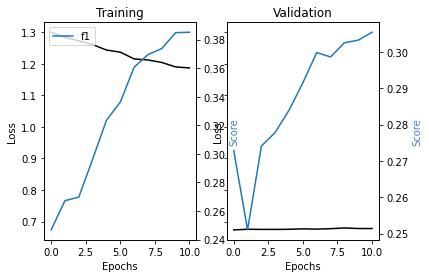

In [68]:
trained_bert, dicmapping = bert_sent_transf_train(bert_model,train_y, embeddings)

In [69]:
embeddings2 = sentence(test_x)

In [ ]:
bert_sent_transf_test(trained_bert, embeddings2, dicmapping, test_y)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Accuracy: 0.49
              precision    recall  f1-score   support

           0       0.55      0.79      0.65      2198
           1       0.39      0.17      0.24      1522
           2       0.07      0.04      0.05       358

    accuracy                           0.49      4078
   macro avg       0.34      0.34      0.31      4078
weighted avg       0.45      0.49      0.44      4078

